In [1]:
import os
import pandas as pd
from IPython.display import IFrame
import folium
import seaborn as sns
import glob
import networkx as nx
import numpy as np

# reading and formatting the data

In [2]:
loc='/Users/wentingjiang/Desktop/mda_kul_local/'

In [5]:
def read_noise_data(folder_path='export_40/'):
   # folder_path = 'export_40/'  # Replace with the path to your folder
    all_files = glob.glob(folder_path + "/*.csv")

    dfs = []
    for filename in all_files:
        data = pd.read_csv(filename, index_col=None, header=0, sep=';')

        data.loc[data['description'] == 'MP08bis - Vrijthof', 'description'] = 'MP 08: bis - Vrijthof'
        #data.loc[data['description'] == 'Naamsestraat 35  Maxim', 'description'] = 'MP 01: Naamsestraat 35 Maxim'

       #location_name = filename.split('.')[0].split('/')[-1].split('_')[-1]
       # print(location_name)
       # data['location']=location_name
        dfs.append(data)

    df_percentiled = pd.concat(dfs, axis=0, ignore_index=True)
    return df_percentiled

## Noise percentiled

In [4]:
df_percentiled= read_noise_data(loc+'export_40/')

In [5]:
df_percentiled.head()

,#object_id,description,result_timestamp,laf005_per_hour,laf005_per_hour_unit,laf01_per_hour,laf01_per_hour_unit,laf05_per_hour,laf05_per_hour_unit,laf10_per_hour,...,laf90_per_hour,laf90_per_hour_unit,laf95_per_hour,laf95_per_hour_unit,laf98_per_hour,laf98_per_hour_unit,laf99_per_hour,laf99_per_hour_unit,laf995_per_hour,laf995_per_hour_unit
0,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 13:00:00.000,65.4,dB(A),64.0,dB(A),60.5,dB(A),58.0,...,47.4,dB(A),46.4,dB(A),45.2,dB(A),44.8,dB(A),44.0,dB(A)
1,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 14:00:00.000,72.2,dB(A),70.8,dB(A),65.8,dB(A),62.6,...,45.2,dB(A),43.9,dB(A),42.4,dB(A),41.4,dB(A),40.4,dB(A)
2,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 15:00:00.000,74.5,dB(A),72.2,dB(A),66.0,dB(A),63.5,...,48.6,dB(A),47.3,dB(A),45.8,dB(A),45.2,dB(A),44.5,dB(A)
3,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 16:00:00.000,72.0,dB(A),70.3,dB(A),65.0,dB(A),62.0,...,45.4,dB(A),43.8,dB(A),42.4,dB(A),41.5,dB(A),40.9,dB(A)
4,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 17:00:00.000,72.6,dB(A),71.2,dB(A),66.6,dB(A),63.6,...,45.5,dB(A),43.8,dB(A),42.3,dB(A),41.4,dB(A),40.7,dB(A)


In [6]:
def create_location_name_dict(df_percentiled):

    pair_dict = {p.split(': ')[0]: p.split(': ')[1] for p in df_percentiled['description']}
    return pair_dict

In [7]:
location_dict=create_location_name_dict(df_percentiled)
location_dict

{'MP 01': 'Naamsestraat 35  Maxim',
 'MP 03': 'Naamsestraat 62 Taste',
 'MP 05': 'Calvariekapel KU Leuven',
 'MP 06': 'Parkstraat 2 La Filosovia',
 'MP 08': 'bis - Vrijthof',
 'MP 02': 'Naamsestraat 57 Xior',
 'MP 07': 'Naamsestraat 81',
 'MP 04': 'His & Hears'}

In [25]:
def truncate_time_to_min(df):
    df['timestamp'] = df['result_timestamp'].str[:-7]
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df.drop('result_timestamp', axis=1)

In [9]:
df_percentiled2 = truncate_time_to_min(df_percentiled)

In [13]:
def generate_noise_network_percentiled(df):
    """
    function unfinished
    """
    
# Create a graph with nodes representing monitoring stations
    G = nx.Graph()
    for station in df['description'].unique():
        G.add_node(station, name=station)

    # Add edges between nodes based on noise level correlations
    for station1 in df['description'].unique():
        for station2 in df['description'].unique():
            if station1 != station2:
                noise1 = df[df['description'] == station1]#['laf005_per_hour'].values
                noise2 = df[df['description'] == station2]#['laf005_per_hour'].values
                result = pd.merge(noise1, noise2, on='result_timestamp', how='inner')

                corr = np.corrcoef(result['laf005_per_hour_x'], result['laf005_per_hour_y'])[0,1]
                if corr > 0.8:
                    G.add_edge(station1, station2, weight=corr)

    # Use community detection algorithm to identify clusters
    communities = nx.community.greedy_modularity_communities(G)

    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, node_color=[communities.index(c) for n,c in nx.get_node_attributes(G,'community').items()], cmap='tab20')
    
    #generate_noise_network_percentiled(df_percentiled2)

## Noise level

In [3]:
loc+'export_42/**/'

'/Users/wentingjiang/Desktop/mda_kul_local/export_42/**/'

In [14]:
df_noise_level = read_noise_data(loc+'export_42/Jul/')

# change to loc+'export_42/**/' for reading all months, but the kernel will crash
# just read data for Jul for now, in this month, there are 7 location of noise data available

In [15]:
df_noise_level.head()

,#object_id,description,result_timestamp,lamax,lamax_unit,laeq,laeq_unit,lceq,lceq_unit,lcpeak,lcpeak_unit
0,255440,MP 02: Naamsestraat 57 Xior,01/07/2022 00:00:00.922,60.9,dB(A),60.0,dB(A),68.25,dB(C),78.43,dB(C)
1,255440,MP 02: Naamsestraat 57 Xior,01/07/2022 00:00:01.922,59.4,dB(A),58.0,dB(A),66.98,dB(C),77.28,dB(C)
2,255440,MP 02: Naamsestraat 57 Xior,01/07/2022 00:00:02.922,56.6,dB(A),55.3,dB(A),62.69,dB(C),73.86,dB(C)
3,255440,MP 02: Naamsestraat 57 Xior,01/07/2022 00:00:03.922,56.3,dB(A),55.3,dB(A),61.21,dB(C),72.30,dB(C)
4,255440,MP 02: Naamsestraat 57 Xior,01/07/2022 00:00:04.922,55.9,dB(A),55.1,dB(A),62.27,dB(C),74.30,dB(C)


In [16]:
df_noise_level.shape

(18748178, 11)

In [17]:
# there are only 7 locations
df_noise_level['description'].unique()

array(['MP 02: Naamsestraat 57 Xior', 'MP 05: Calvariekapel KU Leuven',
       'MP 06: Parkstraat 2 La Filosovia', 'MP 07: Naamsestraat 81',
       'MP 01: Naamsestraat 35  Maxim', 'MP 08: bis - Vrijthof',
       'MP 03: Naamsestraat 62 Taste'], dtype=object)

In [17]:
#test = df_noise_level.copy()
#test['timestamp'] = test['result_timestamp'].str[:-12]
#test.timestamp.unique()

In [18]:
def get_average_noise_level_per_min(df_noise_level):
    
    # reduce to min precision 
    df_noise_level['timestamp'] = df_noise_level['result_timestamp'].str[:-7]
    
    df_noise_level_min=df_noise_level.groupby(['description', 'timestamp'])['lamax'].mean().reset_index()
    
    print(df_noise_level_min.groupby('description').count())
    
    df_noise_level_min_wide = pd.pivot_table(df_noise_level_min, values='lamax', index='timestamp', columns='description')

    # some locations have more timestamps, make them equal length of time stamp
  #  df_noise_level_min_clean = df_noise_level_min_wide.reset_index().dropna()
    df_noise_level_min_clean = df_noise_level_min_wide.reset_index()
    
    # locations have high corr for the noise level
    # print(df_noise_level_min_clean.corr())
    
    # make the precision to minute level (double check later if this is sufficient)
    df_noise_level_min_clean['timestamp'] = pd.to_datetime(df_noise_level_min_clean['timestamp'], errors='coerce')
    df_noise_level_min_clean['timestamp'] = df_noise_level_min_clean['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df_noise_level_min_clean

In [19]:
df_noise_mean=get_average_noise_level_per_min(df_noise_level)

                                  timestamp  lamax
description                                       
MP 01: Naamsestraat 35  Maxim         44640  44640
MP 02: Naamsestraat 57 Xior           44640  44640
MP 03: Naamsestraat 62 Taste          44640  44640
MP 05: Calvariekapel KU Leuven        44640  44640
MP 06: Parkstraat 2 La Filosovia      44640  44640
MP 07: Naamsestraat 81                44640  44640
MP 08: bis - Vrijthof                 44640  44640


In [20]:
df_noise_mean.head()

description,timestamp,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof
0,2022-01-07 00:00,55.053333,54.551667,59.061667,47.128333,46.220000,42.021667,46.626667
1,2022-01-07 00:01,55.851667,49.035000,54.586667,53.373333,50.701667,51.690000,45.803333
2,2022-01-07 00:02,56.543333,50.398333,54.528333,51.421667,53.318333,44.616667,45.496667
3,2022-01-07 00:03,52.256667,46.713333,52.606667,52.250000,53.681667,53.503333,46.746667
4,2022-01-07 00:04,55.598333,51.298333,58.471667,60.530000,61.781667,58.000000,45.343333


In [21]:
df_noise_mean.dtypes

description
timestamp                            object
MP 01: Naamsestraat 35  Maxim       float64
MP 02: Naamsestraat 57 Xior         float64
MP 03: Naamsestraat 62 Taste        float64
MP 05: Calvariekapel KU Leuven      float64
MP 06: Parkstraat 2 La Filosovia    float64
MP 07: Naamsestraat 81              float64
MP 08: bis - Vrijthof               float64
dtype: object

## Noise events

In [22]:
df_noise_events = read_noise_data(loc+'export_41/')

In [23]:
import datetime as dt

In [26]:
df_noise_events2 =truncate_time_to_min(df_noise_events)

In [27]:
def print_na_percent(df):
    print(df.isna().sum()/df.shape[0])

In [28]:
print_na_percent(df_noise_events)

#object_id                                          0.000000
description                                         0.000000
result_timestamp                                    0.000000
noise_event_laeq_model_id                           0.047153
noise_event_laeq_model_id_unit                      1.000000
noise_event_laeq_primary_detected_certainty         0.047153
noise_event_laeq_primary_detected_certainty_unit    0.000000
noise_event_laeq_primary_detected_class             0.047153
noise_event_laeq_primary_detected_class_unit        1.000000
timestamp                                           0.000000
dtype: float64


In [48]:
def remove_noise_undetected(df):
    #print() how many removed
    return df[~df['noise_event_laeq_primary_detected_certainty'].isna()]

In [49]:
df_noise_events_detected=remove_noise_undetected(df_noise_events2)
df_noise_events_detected.shape

(77234, 9)

In [32]:
df_noise_events_detected.groupby('noise_event_laeq_primary_detected_class').count()

# there are a lot of noise event not categorized in a group

,#object_id,description,noise_event_laeq_model_id,noise_event_laeq_model_id_unit,noise_event_laeq_primary_detected_certainty,noise_event_laeq_primary_detected_certainty_unit,noise_event_laeq_primary_detected_class_unit,timestamp
noise_event_laeq_primary_detected_class,,,,,,,,
Human voice - Shouting,5742,5742,5742,0,5742,5742,0,5742
Human voice - Singing,1082,1082,1082,0,1082,1082,0,1082
Music non-amplified,126,126,126,0,126,126,0,126
Nature elements - Wind,113,113,113,0,113,113,0,113
Transport road - Passenger car,47388,47388,47388,0,47388,47388,0,47388
Transport road - Siren,1992,1992,1992,0,1992,1992,0,1992
Unsupported,20791,20791,20791,0,20791,20791,0,20791


In [34]:
df_noise_events_detected['description'].unique()
# only 7 location as well

array(['MP 07: Naamsestraat 81', 'MP 06: Parkstraat 2 La Filosovia',
       'MP 02: Naamsestraat 57 Xior', 'MP 03: Naamsestraat 62 Taste',
       'MP 01: Naamsestraat 35  Maxim', 'MP 08: bis - Vrijthof',
       'MP 05: Calvariekapel KU Leuven'], dtype=object)

In [2]:
# def get_noise_type_by_time_location(df_noise_events_detected):
    
#     #df_noise_events_detected=df_noise_events_detected[df_noise_events_detected['description']==location]

#     df_noise_type=df_noise_events_detected.groupby(['description',
#                                       'timestamp',
#         'noise_event_laeq_primary_detected_class']).count().reset_index()

#     df_noise_type_wide = pd.pivot_table(df_noise_type, values='noise_event_laeq_model_id', index=['description','timestamp'], columns='noise_event_laeq_primary_detected_class')
#     return df_noise_type_wide.reset_index().fillna(0)

#df_noise_type_wide = get_noise_type_by_time_location(df_noise_events_detected)

In [154]:
df_noise_type = df_noise_events_detected.groupby(['description',
                                      'timestamp',
        'noise_event_laeq_primary_detected_class']).count().reset_index()

df_noise_type_wide = pd.pivot_table(df_noise_type, values='noise_event_laeq_model_id', index=
               'timestamp', columns=['description',
                                     'noise_event_laeq_primary_detected_class']).reset_index()
df_noise_type_wide=df_noise_type_wide.fillna(0)

In [131]:
# noise_cat = ['Human voice - Shouting',
#        'Human voice - Singing', 'Music non-amplified',
#        'Nature elements - Wind', 'Transport road - Passenger car',
#        'Transport road - Siren', 'Unsupported']
# # sometimes, many events can happen in one minute at one location
# for i in noise_cat:
#     print(i)
#     print(df_noise_type_wide[i].max())
#     print(df_noise_type_wide[i].median())

In [132]:
# some standard processing to do:
# change the location to include abbreviations only

## Join noise level and events data

In [157]:
# merge noise events type to the minute level noise level
merged_df = df_noise_mean.merge(df_noise_type_wide, on='timestamp', how='left')

/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_10875/1501788542.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_df = df_noise_mean.merge(df_noise_type_wide, on='timestamp', how='left')
/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_10875/1501788542.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = df_noise_mean.merge(df_noise_type_wide, on='timestamp', how='left')


In [158]:
merged_df.shape

(44640, 56)

In [161]:
merged_df_ready=merged_df.fillna(0)
merged_df_ready.head()

,timestamp,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof,"(MP 01: Naamsestraat 35 Maxim, Human voice - Shouting)","(MP 01: Naamsestraat 35 Maxim, Human voice - Singing)",...,"(MP 07: Naamsestraat 81, Nature elements - Wind)","(MP 07: Naamsestraat 81, Transport road - Passenger car)","(MP 07: Naamsestraat 81, Transport road - Siren)","(MP 07: Naamsestraat 81, Unsupported)","(MP 08: bis - Vrijthof, Human voice - Shouting)","(MP 08: bis - Vrijthof, Human voice - Singing)","(MP 08: bis - Vrijthof, Nature elements - Wind)","(MP 08: bis - Vrijthof, Transport road - Passenger car)","(MP 08: bis - Vrijthof, Transport road - Siren)","(MP 08: bis - Vrijthof, Unsupported)"
0,2022-01-07 00:00,55.053333,54.551667,59.061667,47.128333,46.220000,42.021667,46.626667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-07 00:01,55.851667,49.035000,54.586667,53.373333,50.701667,51.690000,45.803333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-07 00:02,56.543333,50.398333,54.528333,51.421667,53.318333,44.616667,45.496667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-07 00:03,52.256667,46.713333,52.606667,52.250000,53.681667,53.503333,46.746667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-07 00:04,55.598333,51.298333,58.471667,60.530000,61.781667,58.000000,45.343333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# Still need to add weather as features

In [162]:
merged_df_ready.describe()

,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof,"(MP 01: Naamsestraat 35 Maxim, Human voice - Shouting)","(MP 01: Naamsestraat 35 Maxim, Human voice - Singing)","(MP 01: Naamsestraat 35 Maxim, Music non-amplified)",...,"(MP 07: Naamsestraat 81, Nature elements - Wind)","(MP 07: Naamsestraat 81, Transport road - Passenger car)","(MP 07: Naamsestraat 81, Transport road - Siren)","(MP 07: Naamsestraat 81, Unsupported)","(MP 08: bis - Vrijthof, Human voice - Shouting)","(MP 08: bis - Vrijthof, Human voice - Singing)","(MP 08: bis - Vrijthof, Nature elements - Wind)","(MP 08: bis - Vrijthof, Transport road - Passenger car)","(MP 08: bis - Vrijthof, Transport road - Siren)","(MP 08: bis - Vrijthof, Unsupported)"
count,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.0,...,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000
mean,52.153951,51.560128,53.492146,50.640573,50.634871,48.908251,45.371358,0.001882,0.000067,0.0,...,0.000067,0.021707,0.000672,0.009162,0.000157,0.000022,0.000022,0.000022,0.000157,0.000022
std,5.794968,6.243740,5.014723,7.529132,7.943239,8.721341,4.227488,0.048231,0.008198,0.0,...,0.008198,0.152634,0.025915,0.105967,0.015697,0.004733,0.004733,0.004733,0.012522,0.004733
min,31.218333,37.026667,44.000000,32.666667,32.805000,28.928333,37.215000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.455000,47.434583,49.948333,45.921667,45.751667,43.058333,42.666667,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.433333,52.366667,53.873333,52.181667,51.951667,50.138333,44.783333,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.852083,55.936667,56.826667,56.210417,56.026667,54.962867,47.175000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,87.630508,84.228333,110.296667,77.756667,84.000000,78.911667,83.070000,3.000000,1.000000,0.0,...,1.000000,4.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [176]:
# Convert the timestamp column to a datetime object
merged_df_ready['timestamp'] = pd.to_datetime(merged_df_ready['timestamp'])

# Create new columns for hour and day of the week
merged_df_ready['hour'] = merged_df_ready['timestamp'].dt.hour
merged_df_ready['day_of_week'] = merged_df_ready['timestamp'].dt.day_name()

# only include the time after 18:00, as Leuven is interested in understanding noise at night
merged_df_ready_small=merged_df_ready[merged_df_ready['hour']>=18]
merged_df_ready_small=pd.get_dummies(merged_df_ready_small)

In [188]:
# load dataset features

col_to_drop=['timestamp',
 'MP 01: Naamsestraat 35  Maxim',
 'MP 02: Naamsestraat 57 Xior',
 'MP 03: Naamsestraat 62 Taste',
 'MP 05: Calvariekapel KU Leuven',
 'MP 06: Parkstraat 2 La Filosovia',
 'MP 07: Naamsestraat 81',
 'MP 08: bis - Vrijthof']
X = merged_df_ready_small.drop(col_to_drop, axis=1)

# predict noise of just one locaton for now
y = np.array(merged_df_ready_small['MP 01: Naamsestraat 35  Maxim'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [182]:
# Import the required libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create a random forest regression model
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

/Users/wentingjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Mean Squared Error: 14.163801537905487
R-squared: 0.1344503878678407


/Users/wentingjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


/Users/wentingjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Text(0, 0.5, 'predicted')

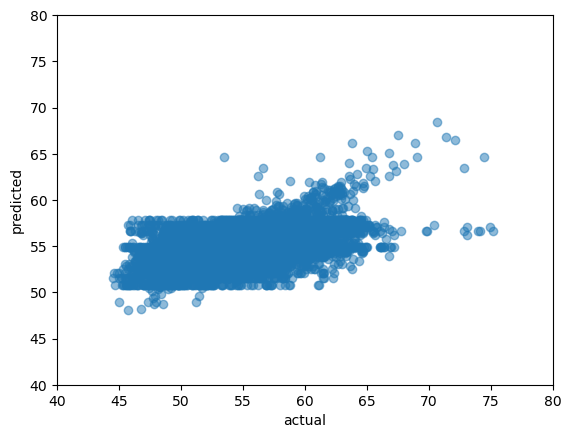

In [186]:
plt.scatter(y_train,regressor.predict(X_train), alpha=0.5)
plt.xlim([40,80])
plt.ylim([40,80])
plt.xlabel('actual')
plt.ylabel('predicted')

(40.0, 80.0)

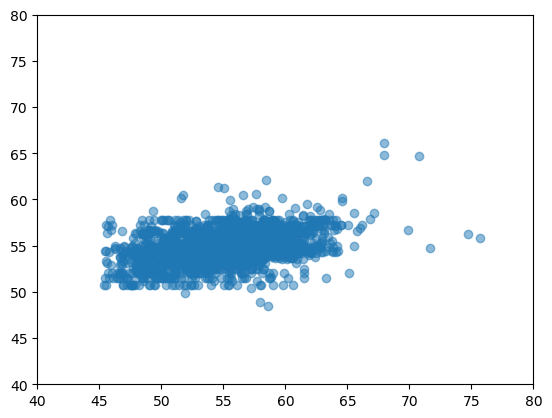

In [187]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlim([40,80])
plt.ylim([40,80])

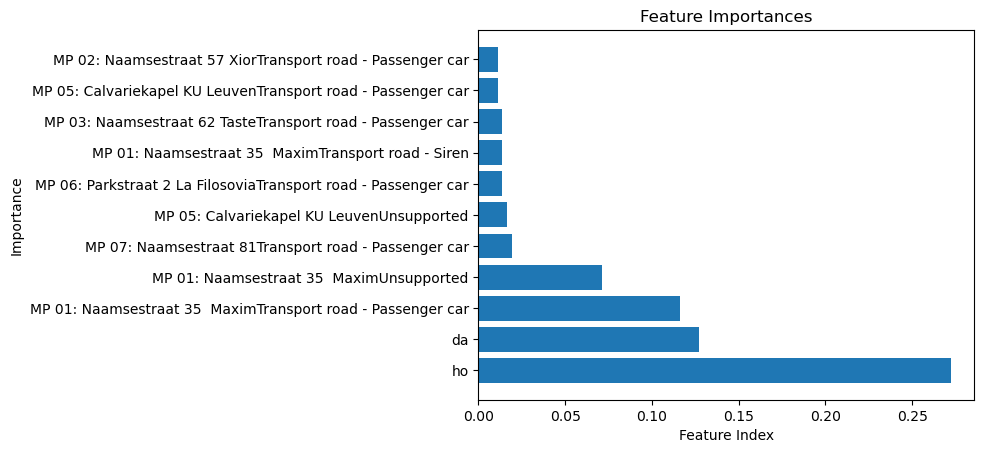

In [203]:
# Get the feature importances
importances = regressor.feature_importances_

# Create a pandas DataFrame with feature importances
#df_importances = pd.DataFrame({'feature': range(X.shape[1]), 'importance': importances})

feature=[i[0]+i[1] for i in X.columns]
df_importances = pd.DataFrame({'feature': feature, 'importance': importances})


# Sort the DataFrame by feature importances in descending order
df_importances = df_importances.sort_values('importance', ascending=False).iloc[:15]

# Create a bar plot of feature importances
plt.barh(df_importances['feature'], df_importances['importance'])
plt.title('Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()
